# Imports e Leitura dos Dados

In [1]:
import holidays
import joblib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
df = pd.read_csv('../data/test_data.csv')

df["date"] = pd.to_datetime(df["date"])

## Funções Auxiliares e Fluxo de validação testes

In [3]:

def create_lagged_features(df, target_col="dauReal", group_col="appId", n_lags=14):
    df = df.sort_values(by=[group_col, "date"]).copy()

    for lag in range(1, n_lags + 1):
        df[f"{target_col}_d-{lag}"] = df.groupby(group_col)[target_col].shift(lag)

    df[f"{target_col}_d"] = df[target_col]

    return df

def regression_report(y_true, y_pred):
    metrics = {
        "MAE": mean_absolute_error(y_true, y_pred),
        "R²": r2_score(y_true, y_pred)
    }

    print("\nRegression Report")
    print("-" * 20)
    for k, v in metrics.items():
        print(f"{k}: {v:.2f}")

    return metrics

df = df.sort_values(by=["appId", "date"])

df_lagged = create_lagged_features(df, n_lags=14)
df_lagged = df_lagged.dropna()

df_lagged["is_weekend"] = df_lagged["date"].dt.weekday.isin([5, 6])

brazil_holidays = holidays.Brazil(years=2024)

df_lagged["is_brazilian_holiday"] = df_lagged["date"].isin(brazil_holidays)

label_encoder = joblib.load("../models/df_encoded.joblib")
df_lagged['category'] = label_encoder.transform(df_lagged['category'])

C:\Users\ailto\AppData\Local\Temp\ipykernel_24056\67735710.py:33: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_lagged["is_brazilian_holiday"] = df_lagged["date"].isin(brazil_holidays)


In [4]:
X = df_lagged[
    [
        'dauReal_d-1', 'dauReal_d-2', 'dauReal_d-3', 
        'dauReal_d-4', 'dauReal_d-5', 'dauReal_d-6', 
        'dauReal_d-7', 'dauReal_d-8', 'dauReal_d-9',
        'dauReal_d-10', 'dauReal_d-11', 'dauReal_d-12',
        'dauReal_d-13', 'dauReal_d-14', 'category', 
        'is_weekend', 'is_brazilian_holiday',
        'newinstalls', 'ratings', 'daily_ratings', 'reviews', 'daily_reviews'
    ]
]

y = df_lagged['dauReal_d']

In [5]:
trained_model = joblib.load("../models/xgb_model.joblib")

y_pred = trained_model.predict(X)

regression_report(y, y_pred)


Regression Report
--------------------
MAE: 41714.58
R²: 0.96


{'MAE': 41714.58357643004, 'R²': 0.9625706578169738}

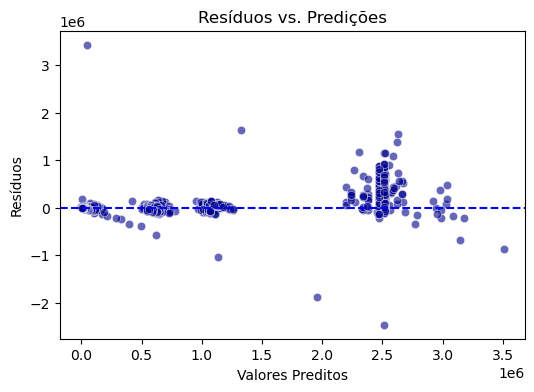

In [6]:
residuos = y - y_pred

plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuos, alpha=0.6, color="darkblue")
plt.axhline(0, color="blue", linestyle="--")

plt.title("Resíduos vs. Predições", fontsize=12)
plt.xlabel("Valores Preditos", fontsize=10)
plt.ylabel("Resíduos", fontsize=10)
plt.show()

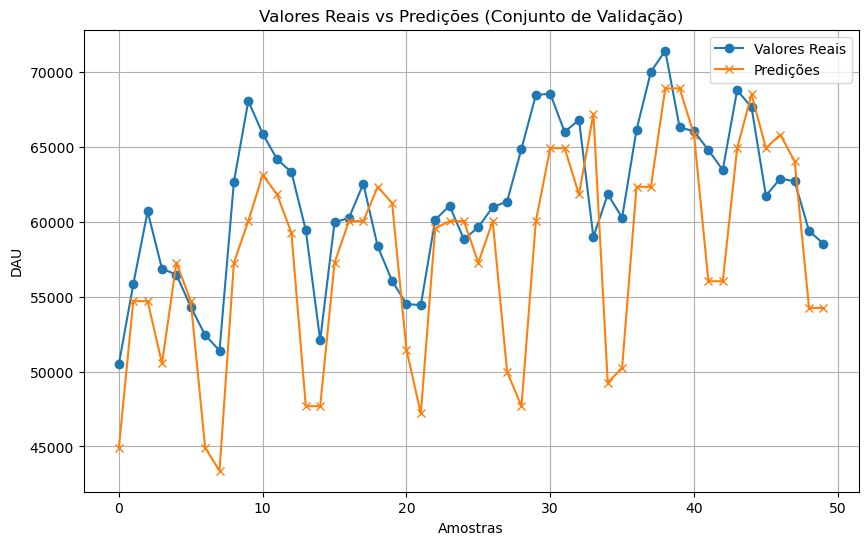

In [7]:
# Comparar valores reais e previstos
plt.figure(figsize=(10, 6))
plt.plot(y.values[:50], label="Valores Reais", marker="o")
plt.plot(y_pred[:50], label="Predições", marker="x")
plt.legend()
plt.title("Valores Reais vs Predições (Conjunto de Validação)")
plt.xlabel("Amostras")
plt.ylabel("DAU")
plt.grid()
plt.show()